In [1]:
import pandas as pd
import numpy as np

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/20.440_Omics/Final_Project_Raw_Counts

# Create seq df (will be gene x sample)
df = pd.read_csv('/content/drive/MyDrive/20.440_Omics/Final_Project_Raw_Counts/Counts.csv')

# Transpose the df (will be sample x gene)
transpose_df = df.transpose()

# Check if all elements of the first row are unique
are_unique = len(transpose_df.columns) == len(set(transpose_df.iloc[0]))

if are_unique:
    print("All elements of the first row are unique.")
else:
    print("Not all elements of the first row are unique.")

# Set the first row as column titles
transpose_df.columns = transpose_df.iloc[0]

# Drop the first row
transpose_df = transpose_df.drop(transpose_df.index[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/20.440_Omics/Final_Project_Raw_Counts
All elements of the first row are unique.


In [2]:
%cd /content/drive/MyDrive/20.440_Omics/Final_Project_Pheno_Data

# Make pheno df (will be sample x phenotype)
pheno_dataset = pd.read_csv("/content/drive/MyDrive/20.440_Omics/Final_Project_Pheno_Data/phenoData.csv")

pheno_dataset = pheno_dataset.set_index(transpose_df.index)

pheno_dataset = pheno_dataset[['sample_name', 'etiology', 'race']]

# Initialize an empty list to store non DCM or NF samples
non_DCM_NF_samples = []

# Iterate over the DataFrame
for index, row in pheno_dataset.iterrows():
    # Check if the etiology is either "PPCM" or "HCM"
    if row['etiology'] in ["PPCM", "HCM"]:
        # Append the sample name to the non_DCM_NF_samples list
        non_DCM_NF_samples.append(row['sample_name'])

# Initialize an empty list to store non DCM or NF samples
non_HCM_NF_samples = []

for index, row in pheno_dataset.iterrows():
    # Check if the etiology is either "PPCM" or "HCM"
    if row['etiology'] in ["DCM", "PPCM"]:
        # Append the sample name to the non_HCM_NF_samples list
        non_HCM_NF_samples.append(row['sample_name'])

/content/drive/MyDrive/20.440_Omics/Final_Project_Pheno_Data


In [3]:
# Make df to compare DCM RNAseq to NF RNAseq
DCM_NF_transpose_df = transpose_df.copy()

# Iterate over the index of DCM_NF_transpose_df
for index in DCM_NF_transpose_df.index:
    # Check if the index is in non_DCM_NF_samples list
    if index in non_DCM_NF_samples:
        # Drop the row from DCM_NF_transpose_df
        DCM_NF_transpose_df.drop(index, inplace=True)

In [4]:
# Make df to compare HCM RNAseq to NF RNAseq
HCM_NF_transpose_df = transpose_df.copy()

# Iterate over the index of HCM_NF_transpose_df
for index in HCM_NF_transpose_df.index:
    # Check if the index is in non_DCM_NF_samples list
    if index in non_HCM_NF_samples:
        # Drop the row from HCM_NF_transpose_df
        HCM_NF_transpose_df.drop(index, inplace=True)

In [5]:
# Make df to compare DCM pheno to NF pheno
DCM_NF_pheno_dataset = pheno_dataset.copy()

# Iterate over the index of DCM_NF_pheno_dataset
for index in DCM_NF_pheno_dataset.index:
    # Check if the index is in non_DCM_NF_samples list
    if index in non_DCM_NF_samples:
        # Drop the row from DCM_NF_pheno_dataset
        DCM_NF_pheno_dataset.drop(index, inplace=True)

In [6]:
# Make df to compare HCM pheno to NF pheno
HCM_NF_pheno_dataset = pheno_dataset.copy()

# Iterate over the index of HCM_NF_pheno_dataset
for index in HCM_NF_pheno_dataset.index:
    # Check if the index is in non_HCM_NF_samples list
    if index in non_HCM_NF_samples:
        # Drop the row from HCM_NF_pheno_dataset
        HCM_NF_pheno_dataset.drop(index, inplace=True)

In [7]:
!pip install -q condacolab
import condacolab
condacolab.install()

!conda install -c bioconda pydeseq2

✨🍰✨ Everything looks OK!
Channels:
 - bioconda
 - conda-forge
Platform: linux-64
Solving environment: / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [8]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [9]:
# Eliminate genes from consideration if total count is less than 10 for DCM_NF_pheno_dataset
genes_to_keep_DCM_NF = DCM_NF_transpose_df.columns[DCM_NF_transpose_df.sum(axis=0) >= 10]
counts_df_DCM_NF = DCM_NF_transpose_df[genes_to_keep_DCM_NF]

In [10]:
# Eliminate genes from consideration if total count is less than 10 for HCM_NF_transpose_df
genes_to_keep_HCM_NF = HCM_NF_transpose_df.columns[HCM_NF_transpose_df.sum(axis=0) >= 10]
counts_df_HCM_NF = HCM_NF_transpose_df[genes_to_keep_HCM_NF]

In [11]:
# Set inference CPU
inference = DefaultInference(n_cpus=8)

In [12]:
# Initiate dds for DCM_NF
dds_DCM_NF = DeseqDataSet(
    counts=counts_df_DCM_NF,
    metadata=DCM_NF_pheno_dataset,
    design_factors="etiology",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

In [13]:
# Initiate dds for HCM_NF
dds_HCM_NF = DeseqDataSet(
    counts=counts_df_HCM_NF,
    metadata=HCM_NF_pheno_dataset,
    design_factors="etiology",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

In [14]:
# Perform deseq2 method on dds_DCM_NF
dds_DCM_NF.deseq2()

Fitting size factors...
... done in 0.72 seconds.

Fitting dispersions...
... done in 80.25 seconds.

Fitting dispersion trend curve...
... done in 1.22 seconds.

Fitting MAP dispersions...
... done in 114.76 seconds.

Fitting LFCs...
... done in 50.92 seconds.

Replacing 546 outlier genes.

Fitting dispersions...
... done in 1.25 seconds.

Fitting MAP dispersions...
... done in 1.29 seconds.

Fitting LFCs...
... done in 0.84 seconds.



In [15]:
# Perform deseq2 method on dds_HCM_NF
dds_HCM_NF.deseq2()

Fitting size factors...
... done in 0.50 seconds.

Fitting dispersions...
... done in 70.86 seconds.

Fitting dispersion trend curve...
... done in 1.13 seconds.

Fitting MAP dispersions...
... done in 97.85 seconds.

Fitting LFCs...
... done in 39.71 seconds.

Replacing 339 outlier genes.

Fitting dispersions...
... done in 0.73 seconds.

Fitting MAP dispersions...
... done in 1.03 seconds.

Fitting LFCs...
... done in 0.79 seconds.



In [16]:
# Initialize DESeq Stat items
stat_res_DCM_NF = DeseqStats(dds_DCM_NF, alpha=0.05, cooks_filter=True, independent_filter=True)

stat_res_HCM_NF = DeseqStats(dds_HCM_NF, alpha=0.05, cooks_filter=True, independent_filter=True)

In [17]:
# Run statistical analysis and call p-values for DCM_NF
stat_res_DCM_NF.run_wald_test()


# Run statistical analysis and call p-values for HCM_NF
stat_res_HCM_NF.run_wald_test()


Running Wald tests...
... done in 19.68 seconds.

Running Wald tests...
... done in 13.57 seconds.



In [18]:
# Make df of statistical results for DCM_NF
stat_res_DCM_NF.summary()
DCM_NF_stat_df = stat_res_DCM_NF.results_df

# Make df of statistical results for HCM_NF
stat_res_HCM_NF.summary()
HCM_NF_stat_df = stat_res_HCM_NF.results_df

Log2 fold change & Wald test p-value: etiology NF vs DCM
                    baseMean  log2FoldChange     lfcSE       stat  \
Unnamed: 0                                                          
ENSG00000000003   285.139928       -0.068145  0.040171  -1.696383   
ENSG00000000005    60.053022       -3.266435  0.172226 -18.965973   
ENSG00000000419  1062.786011       -0.156845  0.033274  -4.713802   
ENSG00000000457   280.334708        0.152668  0.032251   4.733674   
ENSG00000000460    67.915212        0.325797  0.040401   8.064062   
...                      ...             ...       ...        ...   
ENSG00000273487    30.423316       -0.278166  0.078878  -3.526547   
ENSG00000273488     3.587859        0.055208  0.101349   0.544726   
ENSG00000273489    26.038220        0.363573  0.090800   4.004092   
ENSG00000273492    27.198619       -0.055572  0.092557  -0.600414   
ENSG00000273493     4.010927       -0.345670  0.130488  -2.649048   

                       pvalue          padj  

In [19]:
from statsmodels.stats.multitest import multipletests

# Get the p-values from DCM_NF_stat_df
DCM_NF_p_values = DCM_NF_stat_df['pvalue']

# Perform Benjamini-Hochberg correction
DCM_NF_rejected, DCM_NF_corrected_p_values, _, _ = multipletests(DCM_NF_p_values, method='fdr_bh')

# Store the corrected p-values back into the DataFrame
DCM_NF_stat_df['corrected_pvalue'] = DCM_NF_corrected_p_values

# Get the p-values from HCM_NF_stat_df
HCM_NF_p_values = HCM_NF_stat_df['pvalue']

# Perform Benjamini-Hochberg correction
HCM_NF_rejected, HCM_NF_corrected_p_values, _, _ = multipletests(HCM_NF_p_values, method='fdr_bh')

# Store the corrected p-values back into the DataFrame
HCM_NF_stat_df['corrected_pvalue'] = HCM_NF_corrected_p_values


In [20]:
# Make list of genes that are  similarly differenitally expressed in HCM vs NF
# when compared to DCM vs NF
non_DCM_unique_index = []

# Iterate over the index of DCM_NF_stat_df
for index in DCM_NF_stat_df.index:

    if DCM_NF_stat_df.loc[index, 'corrected_pvalue'] <= 0.05:

        # Check if corrected p-value for HCM_NF is also less than 0.05
        if HCM_NF_stat_df.loc[index, 'corrected_pvalue'] < 0.05:

            # Check if signs of log2FoldChange are the same
            if np.sign(DCM_NF_stat_df.loc[index, 'log2FoldChange']) == np.sign(HCM_NF_stat_df.loc[index, 'log2FoldChange']):
                # Append index to the list
                non_DCM_unique_index.append(index)

In [21]:
# Make a copy of the df DCM_NF_stat_df
DCM_NF_differentially_expressed_stat = DCM_NF_stat_df.copy()

# Drop column that are not differntially expressed when compared to HCM_NF_stat_df
DCM_NF_differentially_expressed_stat = DCM_NF_differentially_expressed_stat.drop(non_DCM_unique_index)

# Make data reflect DCM vs NF instead of NF vs DCM
DCM_NF_differentially_expressed_stat['log2FoldChange'] *= -1



In [45]:
# Get number of genes uniquelly differentially expressed with respect to DCM vs NF
DCM_NF_differentially_expressed_stat.shape

(595, 7)

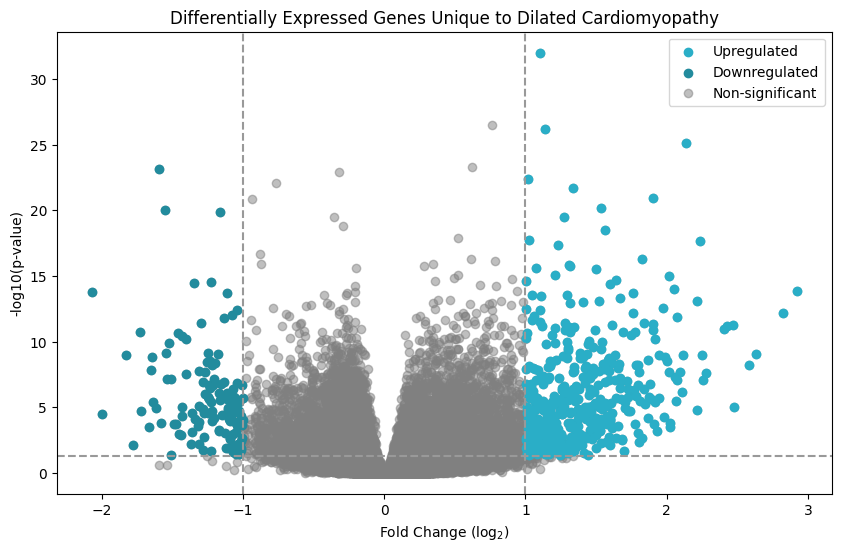

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Set the cutoff values
cutoff_logFC = 1
cutoff_pvalue = 0.05

# Filter the significant genes
significant_genes = DCM_NF_differentially_expressed_stat[
    (DCM_NF_differentially_expressed_stat['log2FoldChange'].abs() > cutoff_logFC) &
    (DCM_NF_differentially_expressed_stat['corrected_pvalue'] < cutoff_pvalue)
]

# Define colors
color_darker = '#228b9d'  # A slightly darker version of #2aaec7 for downregulated
color_original = '#2aaec7'  # Original color for upregulated

# Plot the volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(DCM_NF_differentially_expressed_stat['log2FoldChange'],
            -np.log10(DCM_NF_differentially_expressed_stat['corrected_pvalue']),
            color='grey', alpha=0.5, label='Non-significant')

# Initialize lists to store plotted points for legend handling
downregulated_points = []
upregulated_points = []

# Plot significant genes with custom colors based on log2FoldChange
for index, row in significant_genes.iterrows():
    if row['log2FoldChange'] > -1:
        upregulated_points.append(plt.scatter(row['log2FoldChange'], -np.log10(row['corrected_pvalue']), color=color_original))
    else:
        downregulated_points.append(plt.scatter(row['log2FoldChange'], -np.log10(row['corrected_pvalue']), color=color_darker))

plt.axvline(x=-cutoff_logFC, color='#999999', linestyle='--')
plt.axvline(x=cutoff_logFC, color='#999999', linestyle='--')
plt.axhline(y=-np.log10(cutoff_pvalue), color='#999999', linestyle='--', label=f'p-value = {cutoff_pvalue}')
plt.xlabel('Fold Change (log$_2$)')
plt.ylabel('-log10(p-value)')
plt.title('Differentially Expressed Genes Unique to Dilated Cardiomyopathy')

# Handling legends: pick one representative point from each category for the legend
plt.legend([upregulated_points[0], downregulated_points[0], (plt.scatter([],[], color='grey', alpha=0.5))],
           ['Upregulated', 'Downregulated', 'Non-significant'])

plt.savefig('/content/drive/My Drive/volcano_DCMvsNF_(minus_HCM).png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Make an empty list to house the non-significantly differentially expressed genes for DCM vs HCM
non_significantly_expressed_DCM = []

# Iterate over the index of DCM_NF_differentially_expressed_stat
for index in DCM_NF_differentially_expressed_stat.index:
    # Check if corrected p-value for DCM_NF_differentially_expressed_stat is greater than 0.05 or log2foldchange value is between 1 and -1
    if (DCM_NF_differentially_expressed_stat.loc[index, 'corrected_pvalue'] > 0.05 or
        (DCM_NF_differentially_expressed_stat.loc[index, 'log2FoldChange'] > -1 and
        DCM_NF_differentially_expressed_stat.loc[index, 'log2FoldChange'] < 1)):
        non_significantly_expressed_DCM.append(index)

# Drop rows that are not significantly differentially expressed
DCM_NF_differentially_expressed_stat = DCM_NF_differentially_expressed_stat.drop(non_significantly_expressed_DCM, errors='ignore')

In [24]:
# Get list of differentially expressed genes of interest
DCM_NF_differentially_expressed_list = DCM_NF_differentially_expressed_stat.index.tolist()

In [25]:
# Edit raw count df DCM_NF_transpose_df to only contain these genes of interest
DCM_NF_differentially_expressed_count = DCM_NF_transpose_df.loc[:, DCM_NF_differentially_expressed_list]

In [26]:
# Run differential gene expression for genes of interest for DCM cases with respect to AA or Caucasian
non_DCM_samples = []

# Iterate over the DataFrame
for index, row in pheno_dataset.iterrows():
    # Check if the etiology is either "PPCM" or "HCM" or "NF"
    if row['etiology'] in ["PPCM", "HCM", "NF"]:
        # Append the sample name to the non_DCM_samples list
        non_DCM_samples.append(row['sample_name'])

In [27]:
# Make df to house genes of interest for DCM
DCM_differentially_expressed_count = DCM_NF_differentially_expressed_count.copy()

# Iterate over the index of DCM_differentially_expressed_count
for index in DCM_differentially_expressed_count.index:
    # Check if the index is in non_DCM_samples list
    if index in non_DCM_samples:
        # Drop the row from DCM_NF_transpose_df
        DCM_differentially_expressed_count.drop(index, inplace=True)

In [28]:
# Make df to house DCM pheno data
DCM_pheno_dataset = pheno_dataset.copy()

# Iterate over the index of DCM_pheno_dataset
for index in DCM_pheno_dataset.index:
    # Check if the index is in non_DCM_samples list
    if index in non_DCM_samples:
        # Drop the row from DCM_pheno_dataset
        DCM_pheno_dataset.drop(index, inplace=True)

In [29]:
# Initiate dds for DCM_NF
dds_DCM_race = DeseqDataSet(
    counts=DCM_differentially_expressed_count,
    metadata=DCM_pheno_dataset,
    design_factors="race",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

In [30]:
# Perform deseq2 method on dds_DCM_race
dds_DCM_race.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.24 seconds.

Fitting dispersion trend curve...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 1.23 seconds.

Fitting LFCs...
... done in 0.82 seconds.

Replacing 77 outlier genes.

Fitting dispersions...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 0.21 seconds.

Fitting LFCs...
... done in 0.14 seconds.



In [31]:
# Initialize DESeq Stat items
stat_res_DCM_race = DeseqStats(dds_DCM_race, alpha=0.05, cooks_filter=True, independent_filter=True)

In [32]:
# Run statistical analysis and call p-values for DCM_race
stat_res_DCM_race.run_wald_test()

Running Wald tests...
... done in 0.25 seconds.



In [33]:
# Make df of statistical results for DCM_race
stat_res_DCM_race.summary()
DCM_race_stat_df = stat_res_DCM_race.results_df

Log2 fold change & Wald test p-value: race Caucasian vs AA
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Unnamed: 0                                                                 
ENSG00000002079   0.501758        0.380515  0.376535  1.010570  0.312222   
ENSG00000004939   1.404882        0.025537  0.377465  0.067655  0.946060   
ENSG00000008086  49.542830        0.477411  0.294285  1.622278  0.104744   
ENSG00000011590   0.955155        0.353388  0.292969  1.206229  0.227729   
ENSG00000015413   1.524858        0.165950  0.286942  0.578341  0.563034   
...                    ...             ...       ...       ...       ...   
ENSG00000272788   1.556866        0.515795  0.275274  1.873751  0.060965   
ENSG00000273132   0.194492        0.131170  0.606861  0.216145  0.828875   
ENSG00000273179   1.138248        0.121114  0.345329  0.350721  0.725797   
ENSG00000273409   0.482995        0.620866  0.386609  1.605928  0.108290   
ENSG00000273415   0.621190   

In [34]:
# Get the p-values from DCM_NF_stat_df
DCM_race_p_values = DCM_race_stat_df['pvalue']

# Perform Benjamini-Hochberg correction
DCM_race_rejected, DCM_race_corrected_p_values, _, _ = multipletests(DCM_race_p_values, method='fdr_bh')

# Store the corrected p-values back into the DataFrame
DCM_race_stat_df['corrected_pvalue'] = DCM_race_corrected_p_values

# Make data reflect AA vs Caucasian instead of Caucasian vs AA
DCM_race_stat_df['log2FoldChange'] *= -1

In [35]:
# Initialize a list to store indices
non_enhanced_differential_expression_indices = []

# Iterate over the rows of DCM_race_stat_df
for index, row in DCM_race_stat_df.iterrows():
    # Check if the corrected p-value is <= 0.05, logfold change < 1 or > -1,
    # and the sign of log2FoldChange is different than DCM_NF_differentially_expressed_stat
    if (np.sign(row['log2FoldChange']) != np.sign(DCM_NF_differentially_expressed_stat.loc[index, 'log2FoldChange'])):
        # Append the index to the list
        non_enhanced_differential_expression_indices.append(index)

In [36]:
enhanced_differential_DCM_race_stat_df = DCM_race_stat_df.copy()

# Drop rows based on the list of indices to append
enhanced_differential_DCM_race_stat_df = enhanced_differential_DCM_race_stat_df.drop(non_enhanced_differential_expression_indices)

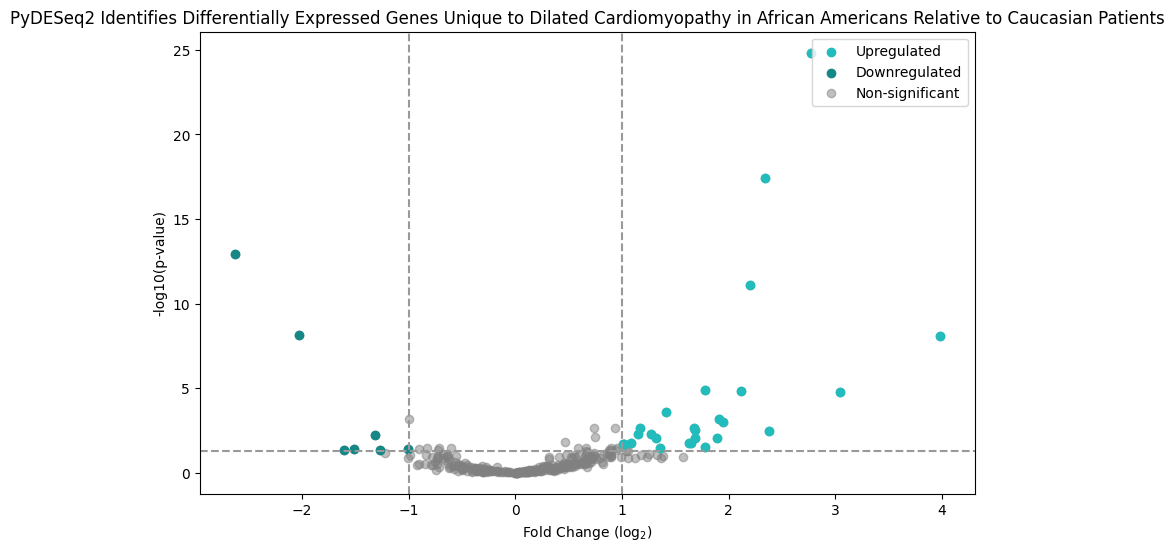

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Set the cutoff value for significance
cutoff_pvalue = 0.05
cutoff_logFC = 1

# Filter the significant genes
significant_genes = enhanced_differential_DCM_race_stat_df[
    (enhanced_differential_DCM_race_stat_df['corrected_pvalue'] <= cutoff_pvalue) &
    (abs(enhanced_differential_DCM_race_stat_df['log2FoldChange']) > cutoff_logFC)
]

# Define colors
color_original = '#22bcbc'  # Original light color
color_darker = '#168787'  # A darker version of '#22bcbc'

# Plot the volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(enhanced_differential_DCM_race_stat_df['log2FoldChange'],
            -np.log10(enhanced_differential_DCM_race_stat_df['corrected_pvalue']),
            color='grey', alpha=0.5, label='Non-significant')

# Initialize lists to store plotted points for legend handling
downregulated_points = []
upregulated_points = []

# Plot significant genes with custom colors based on log2FoldChange
for index, row in significant_genes.iterrows():
    if row['log2FoldChange'] > -1:
        upregulated_points.append(plt.scatter(row['log2FoldChange'], -np.log10(row['corrected_pvalue']), color=color_original))
    else:
        downregulated_points.append(plt.scatter(row['log2FoldChange'], -np.log10(row['corrected_pvalue']), color=color_darker))

plt.axhline(y=-np.log10(cutoff_pvalue), color='#999999', linestyle='--', label=f'p-value = {cutoff_pvalue}')
plt.axvline(x=cutoff_logFC, color='#999999', linestyle='--')
plt.axvline(x=-cutoff_logFC, color='#999999', linestyle='--')
plt.xlabel('Fold Change (log$_2$)')
plt.ylabel('-log10(p-value)')
plt.title('PyDESeq2 Identifies Differentially Expressed Genes Unique to Dilated Cardiomyopathy in African Americans Relative to Caucasian Patients')

# Handling legends: pick one representative point from each category for the legend
plt.legend([upregulated_points[0], downregulated_points[0], (plt.scatter([],[], color='grey', alpha=0.5))],
           ['Upregulated', 'Downregulated', 'Non-significant'])

plt.savefig('/content/drive/My Drive/volcano_DCMvsrace.png', dpi=300, bbox_inches='tight')
plt.show()

Log2 Fold Change Expression in Dilated Cardiomyopathy for African American vs Caucasian Hearts

In [38]:
# Initialize a list to store indices
non_enhanced_differential_expression_indices = []

# Iterate over the rows of DCM_race_stat_df
for index, row in DCM_race_stat_df.iterrows():
    # Check if the corrected p-value is <= 0.05, logfold change < 1 or > -1,
    # and the sign of log2FoldChange is different than DCM_NF_differentially_expressed_stat
    if (row['corrected_pvalue'] > 0.05 or
        (row['log2FoldChange'] < 1 and
        row['log2FoldChange'] > -1)) or \
        (np.sign(row['log2FoldChange']) != np.sign(DCM_NF_differentially_expressed_stat.loc[index, 'log2FoldChange'])):
        # Append the index to the list
        non_enhanced_differential_expression_indices.append(index)


In [39]:
enhanced_differential_DCM_race_stat_df = DCM_race_stat_df.copy()

# Drop rows based on the list of indices to append
enhanced_differential_DCM_race_stat_df = enhanced_differential_DCM_race_stat_df.drop(non_enhanced_differential_expression_indices)



# Make list of indices
enhanced_differential_DCM_race_list = enhanced_differential_DCM_race_stat_df.index.tolist()

In [40]:
enhanced_differential_DCM_race_stat_df['IndexColumn'] = enhanced_differential_DCM_race_stat_df.index

enhanced_differential_DCM_race_stat_df.head(33)

enhanced_differential_DCM_race_stat_df = enhanced_differential_DCM_race_stat_df.sort_values(
    by='log2FoldChange',
    key=lambda col: col.abs(),  # Sort by absolute values
    ascending=False  # Sort in descending order for absolute magnitude
)

enhanced_differential_DCM_race_stat_df.to_csv('/content/drive/My Drive/other_enhanced_differential_DCM_race_stat_df.csv', index=False)





In [41]:
len(enhanced_differential_DCM_race_list)

33

In [42]:
differentially_expressed_genes_DCM_race = DCM_differentially_expressed_count.copy()

differentially_expressed_genes_DCM_race = differentially_expressed_genes_DCM_race.loc[:, enhanced_differential_DCM_race_list]

In [43]:
# Add race to differentially expressed genes
differentially_expressed_genes_DCM_race = pd.concat([differentially_expressed_genes_DCM_race, DCM_pheno_dataset['race']], axis=1)

# Sort by race
differentially_expressed_genes_DCM_race.sort_values(by='race', inplace=True)

# Transpose for GSEA gct file
differentially_expressed_genes_DCM_race = differentially_expressed_genes_DCM_race.transpose()

differentially_expressed_genes_DCM_race.to_csv('/content/drive/My Drive/differentially_expressed_genes_DCM_race_unique.csv', index=True)

differentially_expressed_genes_DCM_race.head(24)

,C01776,P01095,P01077,P01071,P01054,P01045,P01044,P01007,C02546,C02530,...,C02069,C02080,C02081,C02085,C02728,C02724,C02720,C02698,C02660,C02516
ENSG00000073734,0,1,0,0,1,0,0,0,1,0,...,6,16,0,2,0,43,0,0,4,0
ENSG00000125813,0,1,1,0,1,0,0,0,0,0,...,0,0,1,0,3,1,0,0,0,1
ENSG00000147432,0,4,0,0,1,0,0,0,0,17,...,0,1,1,0,0,1,0,0,0,1
ENSG00000152254,1,1,1,1,3,0,0,0,1,0,...,0,2,0,4,1,1,0,0,0,0
ENSG00000159247,0,1,0,1,3,0,1,7,15,11,...,0,0,0,0,0,1,0,5,1,0
ENSG00000159708,9,8,1,18,44,13,0,27,26,51,...,2,1,14,1,0,3,0,6,7,1
ENSG00000205020,0,0,0,1,0,0,8,0,24,10,...,0,0,0,2,0,3,0,0,0,0
ENSG00000211625,23,1,3,0,3,0,1,0,32,5,...,11,6,1,0,0,722,0,1,2,0
ENSG00000211630,74,0,0,1,3,6,0,0,110,16,...,0,0,0,0,0,61,0,1,27,0
ENSG00000211638,73,3,1,1,3,0,3,2,220,19,...,0,4,4,9,1,683,1,5,25,1
